# Week 5: GANs

Our goal is to use Generative Adversarial Networks to generate images to see if we can pass the Discriminator.  This is based on a Kaggle competition.  Description from Kaggle:

A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. This generator is trained using a discriminator.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

Your task is to build a GAN that generates 7,000 to 10,000 Monet-style images. 

Note: As per the recommendation from the Kaggle competition, I'll be using the Monet CycleGAN Tutorial as a reference guide for the architectural approach.

#### Data description


    monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
    monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
    photo_jpg - 7028 photos sized 256x256 in JPEG format
    photo_tfrec - 7028 photos sized 256x256 in TFRecord format


In [1]:
# !pip install tensorflow-addons

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, initializers
# import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

tf.__version__

ModuleNotFoundError: No module named 'kaggle_datasets'

In [ ]:
# Based on my experience with the previous assignemnts and slow training times, 
# I'm going to attempt to use the Kaggle Notebook which provides access to TPU and GPU hardware for training

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # Use the Tensor Processing Unit
    print('Device:', tpu.master()) # Print device information
    tf.config.experimental_connect_to_cluster(tpu) # Connect to the runtime
    tf.tpu.experimental.initialize_tpu_system(tpu) # Initialize the TPU
    strategy = tf.distribute.experimental.TPUStrategy(tpu) # Set the strategy to use a TPU
except:
    # If setting up a TPU failed, then use default strategy using the available CPU or GPU
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE # Automatically select optimal number of parallel cells
    
print(tf.__version__)  # Print version

Number of replicas: 1
2.15.0


In [ ]:
# If running this in Kaggle Notebook, import the data in the right pane first
GCS_PATH = KaggleDatasets().get_gcs_path() # get dataset path
print(GCS_PATH)

# If you inspect the dataset, there are two sets of directories, one for jpeg and one tfrec.  
# tfrec is a data format specificially for training in tensorflow

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

MONET_FILENAMES_JPG = tf.io.gfile.glob(str(GCS_PATH + '/monet_jpg/*.jpg'))
print('Monet TFRecord Files:', len(MONET_FILENAMES_JPG))

# PHOTO_FILENAMES_JPG = tf.io.gfile.glob(str(GCS_PATH + '/photo_jpg/*.jpg'))
# print('Photo TFRecord Files:', len(PHOTO_FILENAMES_JPG))

gs://kds-597e344c0d8b552bfcd22a7fa6b9a438d05f236f432f40c9c8bdb136
Monet TFRecord Files: 5
Photo TFRecord Files: 20
Monet TFRecord Files: 300


In [ ]:
def parse_example(example_proto):
    feature_description = {
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example_proto, feature_description)

# Let's investigate a tfrecord and see the format
tfrecord_file = MONET_FILENAMES[0]
raw_dataset = tf.data.TFRecordDataset(tfrecord_file)

# Iterate over the dataset to get one record
for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())  # Parse the serialized data
    
    # Print the keys of the parsed example
    keys = list(example.features.feature.keys())
    print(keys)

['image_name', 'target', 'image']


In [ ]:
# Some helper functions

IMAGE_SIZE = [256, 256]
CHANNELS = 3 # RGB

# Function for decoding an image
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = (tf.cast(image, tf.float32) / 127.5) - 1 # Normalize the RGB values in the image to range [-1, 1]
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # reshape the image to the correct dimensions [256, 256, 3]
    return image

def read_tfrecord(example):
    tfrecord_format = {  # Define the structure of the tfrecord based on example above
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

# Define the function to extract the image from the files.
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(16, drop_remainder=True)  # Use a larger batch size
    dataset = dataset.repeat()  # Repeat the dataset indefinitely
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset



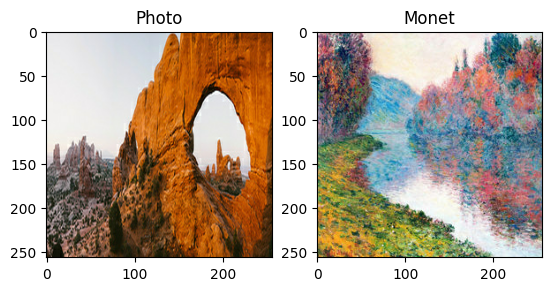

In [ ]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True)

example_monet = next(iter(monet_ds.skip(1)))
example_photo = next(iter(photo_ds.skip(1)))

# Example of monet and regular photo

plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

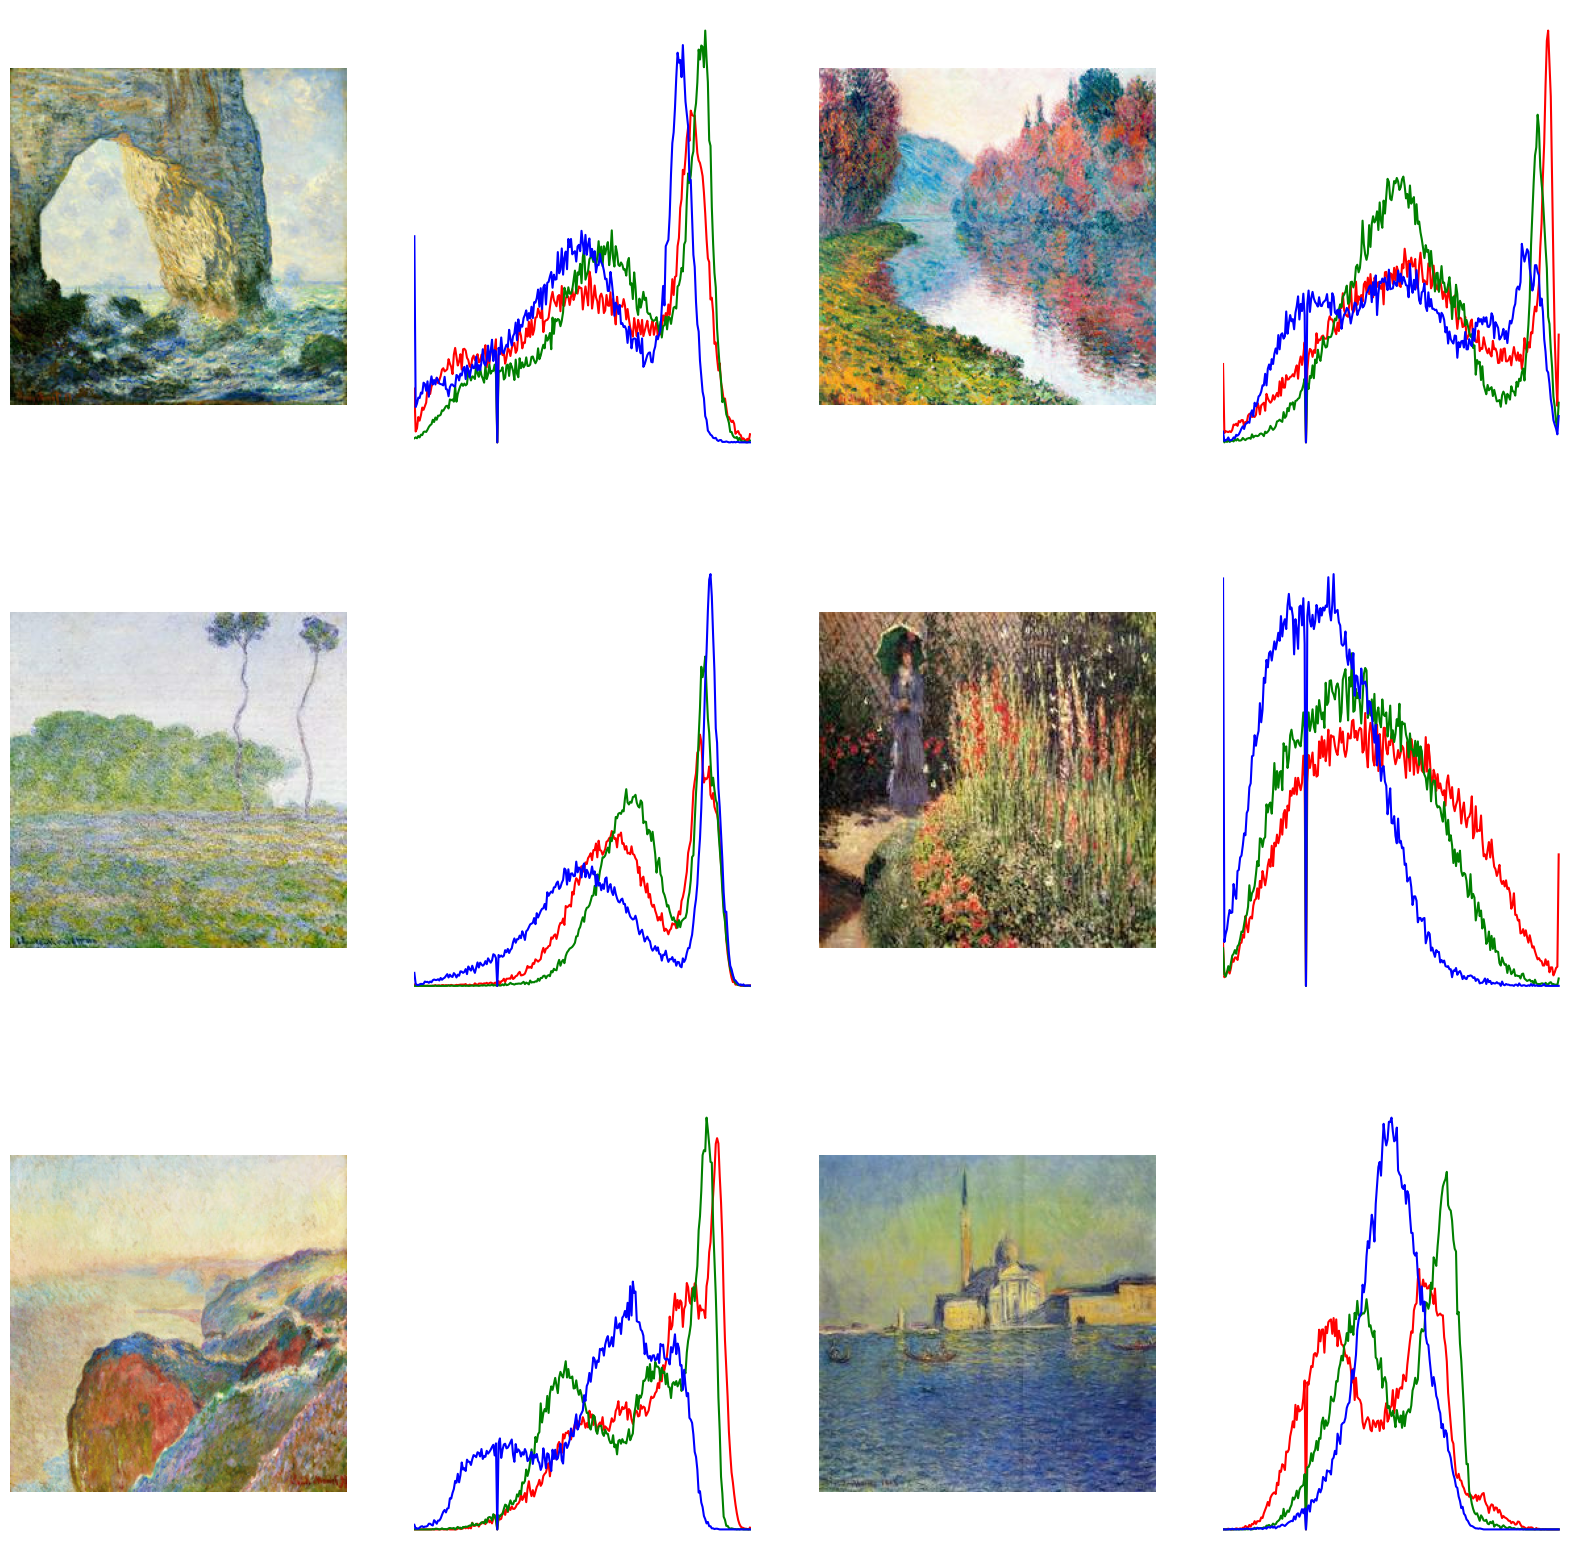

In [ ]:
# Visualize color distribution for dataset

# Function to plot color histograms
def plot_color_histogram(image):
    colors = ('r', 'g', 'b')
    for i, color in enumerate(colors):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        plt.plot(hist, color=color)
        plt.xlim([0, 256])

# Visualize example photos with histograms
plt.figure(figsize=(20, 20))

n_images = 6
w = int(n_images ** 0.5)
h = math.ceil(n_images / w)

for idx, batch in enumerate(monet_ds.take(n_images)):
    img = batch.numpy()[0]  # Extract the image from the batch and convert to numpy array
    img = (img + 1) / 2  # Scale image back to [0, 1] range for visualization

    plt.subplot(h, w*2, idx*2 + 1)
    plt.imshow(img)
    plt.axis("off")
    
    plt.subplot(h, w*2, idx*2 + 2)
    plot_color_histogram((img * 255).astype(np.uint8))  # Convert image to uint8 for histogram
    plt.axis("off")

plt.show()


In [ ]:
# Helper function for instance_normalization
class InstanceNormalization(layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(
            shape=(input_shape[-1],),
            initializer=initializers.RandomNormal(mean=0.0, stddev=0.02),
            trainable=True,
            name='gamma'
        )
        self.beta = self.add_weight(
            shape=(input_shape[-1],),
            initializer=initializers.Zeros(),
            trainable=True,
            name='beta'
        )
        super(InstanceNormalization, self).build(input_shape)

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        return self.gamma * normalized + self.beta

In [ ]:
# I will be using UNET architecture (encoder/decoder structure with skip connections for the generator network of our CycleGAN)

# The first step is to downsampler to capture high level features of the image

# Using instance normalization.  We do this to maintain the integrity of individual images without introducing artifacts
# def instance_normalizer(x): # Takes a 4D tensor with shape [batch_size, height, width, channels]
#     epsilon = 1e-5 # Prevents dividing by zero
#     mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
#     normalized = (x - mean) / tf.sqrt(variance + epsilon)
#     # gamma and beta are learnable parameters used to scale and shift the normalized tensor.
#     gamma = tf.Variable(initializers.RandomNormal(mean=0.0, stddev=0.02)(shape=[x.shape[-1]]), trainable=True)
#     beta = tf.Variable(initializers.Zeros()(shape=[x.shape[-1]]), trainable=True)
#     return gamma * normalized + beta

def downsample(
    filters, # number of output channels for the convolutional layer
    size, # size of the convolutional kernal which operates over the image
    apply_instancenorm=True # Using instance normalization as default.  We do this to maintain the integrity of individual images without introducing artifacts
):
    strides = 2 # The spatial dimension will be reduced by 2 on each pass
    initializer = tf.random_normal_initializer(0., 0.02) # Initialize the weights of the CNN using a normal distribution

    downsampler = keras.Sequential([ # Create a new sequential model
        layers.Conv2D(filters, size, strides=strides, padding='same', # add Convolutional layer
            kernel_initializer=initializer, use_bias=False)
    ])

    if apply_instancenorm:
        downsampler.add(InstanceNormalization())
#         layers.Lambda(instance_normalizer, output_shape=lambda s: s)

    downsampler.add(layers.LeakyReLU()) # Avoid dying ReLU problem, so neuron can keep learning

    return downsampler

# Next we'll create an upsampler to increase the spatial dimensions and construct the image

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    upsampler = keras.Sequential([ # Create a new sequential model
        layers.Conv2DTranspose(filters, size, strides=2,
            padding='same', # Padding set to same, so that the kernal can cover the entire image, but the ouput will still be reduced
            kernel_initializer=initializer,use_bias=False),
#         layers.Lambda(instance_normalizer, output_shape=lambda s: s)
        InstanceNormalization()
    ])
    
    if apply_dropout:
        upsampler.add(layers.Dropout(0.5))

    upsampler.add(layers.ReLU())

    return upsampler



In [ ]:
# Building the generator

def Generator():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    input_layer = tf.keras.layers.Input(shape=[256, 256, 3])

    # Downsampling
    x1 = downsample(64, 4, apply_instancenorm=False)(input_layer)  # (batch size, 128, 128, 64)
    x2 = downsample(128, 4)(x1)  # (64, 64, 128)
    x3 = downsample(256, 4)(x2)  # (32, 32, 256)
    x4 = downsample(512, 4)(x3)  # (16, 16, 512)
    x5 = downsample(512, 4)(x4)  # (8, 8, 512)
    x6 = downsample(512, 4)(x5)  # (4, 4, 512)
    x7 = downsample(512, 4)(x6)  # (2, 2, 512)
    x8 = downsample(512, 4)(x7)  # (1, 1, 512)
    
    # Upsampling
    u1 = upsample(512, 4, apply_dropout=True)(x8)  # (batch size, 2, 2, 1024)
    u1 = layers.Concatenate()([u1, x7])
    u2 = upsample(512, 4, apply_dropout=True)(u1)  # (4, 4, 1024)
    u2 = layers.Concatenate()([u2, x6])
    u3 = upsample(512, 4, apply_dropout=True)(u2)  # (8, 8, 1024)
    u3 = layers.Concatenate()([u3, x5])
    u4 = upsample(512, 4)(u3)  # (16, 16, 1024)
    u4 = layers.Concatenate()([u4, x4])
    u5 = upsample(256, 4)(u4)  # (32, 32, 512)
    u5 = layers.Concatenate()([u5, x3])
    u6 = upsample(128, 4)(u5)  # (64, 64, 256)
    u6 = layers.Concatenate()([u6, x2])
    u7 = upsample(64, 4)(u6)  # (28, 128, 128)
    u7 = layers.Concatenate()([u7, x1])
    
    # Final layer
    last_layer = layers.Conv2DTranspose(CHANNELS, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')  # (bs, 256, 256, 3)
    x = last_layer(u7)

    return keras.Model(inputs=input_layer, outputs=x)

# Building the disriminator

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    # gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    input_layer = layers.Input(shape=[256, 256, 3], name='input_image')
    
    # Downsampling layers
    x = downsample(64, 4, False)(input_layer)  # (batch size, 128, 128, 64)
    x = downsample(128, 4)(x)          # (64, 64, 128)
    x = downsample(256, 4)(x)          # (32, 32, 256)
    # Zero padding and convolution
    x = layers.ZeroPadding2D()(x)                     # (34, 34, 256)
    x = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(x)  # (31, 31, 512)
    # Normalization and activation
#     x = layers.Lambda(instance_normalizer, output_shape=lambda s: s)(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU()(x)
    # Additional padding and final convolution
    x = layers.ZeroPadding2D()(x)                     # (batch size, 33, 33, 512)
    x = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x)  # (batch size, 30, 30, 1)
    
    return keras.Model(inputs=input_layer, outputs=x)

# Wrap in strategy to make sure we use TPUs (if available)
with strategy.scope():
    photo_to_monet_gen = Generator()
    monet_to_photo_gen = Generator()

    monet_discrim = Discriminator()
    photo_discrim = Discriminator()
    
    photo_to_monet_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    monet_to_photo_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discrim_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discrim_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


Now we will create the CycleGAN model, inheriting from the keras CycleGAN model and making modifications.  At this point, you may wonder why it's important for us to be able to convert monet-style photos to regular photos if our go from photos to monet.
- A photo transformed into a Monet painting should still resemble the original photo in terms of content (e.g., objects, scenes).
- If a photo of a landscape is transformed into a Monet painting, transforming it back into a photo should yield a landscape photo, not an arbitrary or unrelated image.
- A specific object in a photo (like a tree) should still be recognizable after the transformation to a painting and back.
- Ensuring that transformations are reversible helps the model learn more stable and reliable mappings between domains.
- Understanding how a Monet painting relates to a photo helps improve the model's ability to generate realistic Monet paintings from photos.

In [ ]:
class CycleGAN(tf.keras.Model):
    def __init__(self, generator_g, generator_f, discriminator_x, discriminator_y, lambda_cycle=2):
        super(CycleGAN, self).__init__()
        self.generator_g = generator_g
        self.generator_f = generator_f
        self.discriminator_x = discriminator_x
        self.discriminator_y = discriminator_y
        self.lambda_cycle = lambda_cycle # Level of importance on the cycle consistency (monet back to photo)
        self.lambda_identity = .1
        
    def compile(self, gen_optimizer_g, gen_optimizer_f, disc_optimizer_x, disc_optimizer_y, gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(CycleGAN, self).compile()
        self.gen_optimizer_g = gen_optimizer_g  # Optimizer for generator_g
        self.gen_optimizer_f = gen_optimizer_f  # Optimizer for generator_f
        self.disc_optimizer_x = disc_optimizer_x  # Optimizer for discriminator_x
        self.disc_optimizer_y = disc_optimizer_y  # Optimizer for discriminator_y
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_x, real_y = batch_data

        with tf.GradientTape(persistent=True) as tape:
            fake_y = self.generator_g(real_x, training=True) # Convert photo to monet
            cycled_x = self.generator_f(fake_y, training=True) # Convert monet to photo
            
            fake_x = self.generator_f(real_y, training=True) # Convert monet to photo
            cycled_y = self.generator_g(fake_x, training=True) # Convert photo to monet

            same_x = self.generator_f(real_x, training=True) # Pass a photo into the monet to photo generator, should result in same photo
            same_y = self.generator_g(real_y, training=True) # Pass a monet into the photo to monet generator, should result in same monet

            disc_real_x = self.discriminator_x(real_x, training=True) # Discriminate real photos
            disc_real_y = self.discriminator_y(real_y, training=True) # Discriminate real monets
            
            disc_fake_x = self.discriminator_x(fake_x, training=True) # Discriminate fake photos
            disc_fake_y = self.discriminator_y(fake_y, training=True) # Discriminate fake monets

            gen_g_loss = self.gen_loss_fn(disc_fake_y) # Monet generator loss
            gen_f_loss = self.gen_loss_fn(disc_fake_x) # Photo generator loss

            total_cycle_loss = self.cycle_loss_fn(real_x, cycled_x, self.lambda_cycle) + self.cycle_loss_fn(real_y, cycled_y, self.lambda_cycle) # Total cycle loss
            total_gen_g_loss = gen_g_loss + total_cycle_loss + self.identity_loss_fn(real_y, same_y, self.lambda_identity) # Total monet gen loss
            total_gen_f_loss = gen_f_loss + total_cycle_loss + self.identity_loss_fn(real_x, same_x, self.lambda_identity) # Total photo gen loss

            disc_x_loss = self.disc_loss_fn(disc_real_x, disc_fake_x) # Monet disc loss
            disc_y_loss = self.disc_loss_fn(disc_real_y, disc_fake_y) # photo disc loss

        grads_g = tape.gradient(total_gen_g_loss, self.generator_g.trainable_variables)
        grads_f = tape.gradient(total_gen_f_loss, self.generator_f.trainable_variables)
        grads_disc_x = tape.gradient(disc_x_loss, self.discriminator_x.trainable_variables)
        grads_disc_y = tape.gradient(disc_y_loss, self.discriminator_y.trainable_variables)

        self.gen_optimizer_g.apply_gradients(zip(grads_g, self.generator_g.trainable_variables))
        self.gen_optimizer_f.apply_gradients(zip(grads_f, self.generator_f.trainable_variables))
        self.disc_optimizer_x.apply_gradients(zip(grads_disc_x, self.discriminator_x.trainable_variables))
        self.disc_optimizer_y.apply_gradients(zip(grads_disc_y, self.discriminator_y.trainable_variables))

        return {
            "gen_g_loss": total_gen_g_loss,
            "gen_f_loss": total_gen_f_loss,
            "disc_x_loss": disc_x_loss,
            "disc_y_loss": disc_y_loss
        }
    

In [ ]:
# Create loss functions

with strategy.scope():
    def discriminator_loss(real_output, fake_output):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
        fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss # To balance the learning between generator and discriminator
    
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
with strategy.scope():
    def cycle_consistency_loss(real_image, cycled_image, lambda_cycle=2):
        # Calculate the L1 loss (mean absolute difference) between real and cycled images
        loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
        # Scale the loss by lambda_cycle
        return lambda_cycle * loss
    
with strategy.scope():
    def identity_loss(real_image, same_image, lambda_identity=5): # Setting lambda identity smaller than cycle consistency lambda, to give it less weight
        # Calculate the L1 loss between real and same images
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return lambda_identity * loss

### Training the CycleGan Model

In [ ]:
with strategy.scope():
    cyclegan = CycleGAN(photo_to_monet_gen, monet_to_photo_gen, monet_discrim, photo_discrim)
    
    cyclegan.compile(
    gen_optimizer_g=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    gen_optimizer_f=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    disc_optimizer_x=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    disc_optimizer_y=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss,
    disc_loss_fn=discriminator_loss,
    cycle_loss_fn=cycle_consistency_loss,
    identity_loss_fn=identity_loss
)
    
cyclegan.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=5
)

Epoch 1/5


2024-07-04 08:09:37.140992: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 517.262, expected 2065.43
2024-07-04 08:09:37.141052: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 774.544, expected 3093.14
2024-07-04 08:09:37.141062: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 782.168, expected 3123.65
2024-07-04 08:09:37.141071: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 538.042, expected 2148.95
2024-07-04 08:09:37.141080: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 778.235, expected 3109.79
2024-07-04 08:09:37.141089: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 1173.56, expected 4691.17
2024-07-04 08:09:37.141097: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 1169.58, expected 4675.32
2024-07-04 08:09:37.141106: E external/local_xla/xla/se

    938/Unknown 944s 885ms/step - disc_x_loss: 1.2018 - disc_y_loss: 1.0766 - gen_f_loss: 1.6059 - gen_g_loss: 1.7668

In [ ]:
# Print out example photos

_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = photo_to_monet_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [ ]:
# Create submission file
import PIL
! mkdir ../images

i = 1
for img in photo_ds:
    if (i % 500 == 0):
        print(f"Made {i} images")
    prediction = photo_to_monet_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1
    
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

# Analysis

This was a challenging project with a lot of moving parts.  The final output resulted in a score of 82.27, which I'm fairly happy with.  However, when viewing examples of the output images, I was surprised to find that they were only subtly different than the original photos, with some variation in color satuation and level of detail.

I tweaked some hyperparameters, namely the weight of cycle and identity loss functions, with minimal change in the results.

In the future, I'd like to run this same sort of model on different types of images and possibly different artist styles to see if I get similar results.